# Measuring changes in polarisation using Singular Value Decomposition of Random Dot Product Graphs
 
Article: https://networksci.peercommunityin.org/articles/rec?id=217
 
**Data folder structure:**
- `data/1/`: Contains daily files. Each file covers a single day, from 00:00 of one day to 00:00 of the next.
- `data/2/`: Contains cumulative files. Each file starts at 2025-02-23 and ends at the date specified in the filename.
- `data/3/`: Contains files for 12-hour intervals. Each file covers a period from a start date and time to an end date and time, both specified in the filename in U

In [1]:
import pathlib
import polars as pl
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import norm

# Methods to calculate svd
from numpy.linalg import svd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd

In [7]:
DATA_PATH = "../data/1/"
DATA_FILES = sorted(pathlib.Path(DATA_PATH).glob("*.csv"))

mapping_nodes_with_zero_degree = {}
graphs = {}

for file in DATA_FILES:
    df = pd.read_csv(file, index_col=0)
    
    # Remove self-loops 
    np.fill_diagonal(df.values, 0)
    
    # Calculate node degrees to identify zero-degree nodes
    node_degrees = df.sum(axis=1) + df.sum(axis=0)
    
    # Identify nodes with zero degree
    zero_degree_nodes = node_degrees[node_degrees == 0].index.tolist()
    mapping_nodes_with_zero_degree[file.stem] = zero_degree_nodes
    
    # Remove zero-degree nodes from the adjacency matrix
    df = df.drop(index=zero_degree_nodes, columns=zero_degree_nodes)
    
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)
    graphs[file.stem] = G

mapping = pl.DataFrame({
    "file": list(mapping_nodes_with_zero_degree.keys()),
    "zero_degree_nodes_count": [len(nodes) for nodes in mapping_nodes_with_zero_degree.values()]
})

print(f"Graphs loaded: {len(graphs)}")
print(f"First graph: {list(graphs.keys())[0]}")
print(f"Last graph: {list(graphs.keys())[-1]}")

mapping.describe()

Graphs attributes:
DiGraph with 5 nodes and 3 edges
{('UCvbBfztEPSHwfsMIQRXtBcg', 'UCWU7Mg-Eupe3q2t9v0xMxEQ'): 1, ('UCzMaZj8CbL-kL0fkaSTnN1Q', 'UC_DoMcsbJRxFlG3lS92Ow3g'): 1, ('UC0YXIr51P5BOeloL4tRg3UQ', 'UC_DoMcsbJRxFlG3lS92Ow3g'): 1}
Graphs loaded: 52
First graph: 2025-02-23_2025-02-24
Last graph: 2025-04-15_2025-04-16


statistic,file,zero_degree_nodes_count
str,str,f64
"""count""","""52""",52.0
"""null_count""","""0""",0.0
"""mean""",null,775.5
"""std""",null,491.201548
"""min""","""2025-02-23_2025-02-24""",10.0
"""25%""",null,408.0
"""50%""",null,636.0
"""75%""",null,1057.0
"""max""","""2025-04-15_2025-04-16""",2158.0


In [8]:
from functools import partial
import concurrent.futures as cf

try:
    from joblib import Parallel, delayed 
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False

# Computes the full SVD of matrix A and returns the top k singular values.
def truncated_svd(A, k=None, include_u_v=False):
    S = svd(A, compute_uv=False, full_matrices=False)
    if k is None:
        k = len(S)
    S_k = S[:k]
    if include_u_v:
        U, _, Vh = svd(A, full_matrices=False)
        return S_k, U[:, :k], Vh[:k, :]
    return S_k


# Computes the log-likelihood for a given q
def compute_ll_for_q(sv: np.ndarray, p: int, q: int):
    q = int(q)
    S1 = sv[:q]
    S2 = sv[q:]

    if len(S2) == 0 or p <= 2:
        return (q, float(-np.inf))

    mu1 = np.mean(S1) if len(S1) else 0.0
    mu2 = np.mean(S2) if len(S2) else 0.0

    if len(S1) > 1:
        s1_squared = np.var(S1, ddof=1)
    else:
        s1_squared = 0.0

    if len(S2) > 1:
        s2_squared = np.var(S2, ddof=1)
    else:
        s2_squared = 0.0

    sigma2 = ((q - 1) * s1_squared + (p - q - 1) * s2_squared) / (p - 2)
    if not np.isfinite(sigma2) or sigma2 <= 0:
        return (q, float(-np.inf))

    sigma = np.sqrt(sigma2)

    ll = 0.0
    if len(S1):
        ll += float(np.sum(norm.logpdf(S1, mu1, sigma)))
    if len(S2):
        ll += float(np.sum(norm.logpdf(S2, mu2, sigma)))

    return (q, ll)

# Estimate the embedding dimension using the profile likelihood method
def embedding_dimension(singular_values, k=None, n_jobs: int = -1):
    
    if k is None:
        k = len(singular_values)

    sv = np.array(singular_values[:k], dtype=float)
    p = len(sv)

    if p <= 2:
        return 1

    qs = list(range(1, p))

    if n_jobs == 1:
        best_ll = float(-np.inf)
        d_hat = 1
        for q in qs:
            _, ll = compute_ll_for_q(sv, p, q)
            if ll > best_ll:
                best_ll = ll
                d_hat = q
        return d_hat

    if _HAVE_JOBLIB:
        results = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(compute_ll_for_q)(sv, p, q) for q in qs
        )
    else:
        max_workers = None if n_jobs in (None, -1) else int(n_jobs)
        func = partial(compute_ll_for_q, sv, p)
        with cf.ProcessPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(func, qs))

    if not results:
        return 1

    best_q, _best_ll = max(results, key=lambda t: t[1]) 
    return int(best_q)

In [9]:
# Extract available date strings from graph keys
date_strings = sorted(list(set([re.search(r'(\d{4}-\d{2}-\d{2})', key).group(1) for key in graphs.keys()]))) # type: ignore
print(f"Available dates: {date_strings}")

Available dates: ['2025-02-23', '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27', '2025-02-28', '2025-03-01', '2025-03-02', '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-22', '2025-03-23', '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28', '2025-03-29', '2025-03-30', '2025-03-31', '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-05', '2025-04-06', '2025-04-07', '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11', '2025-04-12', '2025-04-13', '2025-04-14', '2025-04-15']


In [ ]:
# Create graphs by windowed dates
def measure_polarization(graphs, steps=1, accum=False):
    embedded_dimensions = []
    window_dates = []
    
    # Iterate over date strings in windows
    for i in range(0, len(date_strings) - steps + 1, steps):
        start_date = date_strings[0] if accum else date_strings[i]
        end_date = date_strings[i + steps - 1]
        
        window_graphs = []
        for name, graph in graphs.items():
            graph_date = re.search(r'(\d{4}-\d{2}-\d{2})', name).group(1) # type: ignore
            if start_date <= graph_date <= end_date:
                window_graphs.append(graph)

        if not window_graphs:
            raise ValueError(f"No graphs found in the date range {start_date} to {end_date}")
        
        # Combine graphs in the window
        if len(window_graphs) > 1:
            combined_graph = nx.compose_all(window_graphs)
            
            # Print if there are isolated nodes in the combined graph (it should not happen)
            isolated_nodes = list(nx.isolates(combined_graph))
            if isolated_nodes:
                print(f"Isolated nodes found in combined graph from {start_date} to {end_date}: {isolated_nodes}")
        else:
            combined_graph = window_graphs[0]
        
        adj_matrix = nx.adjacency_matrix(combined_graph).todense()
        sv = truncated_svd(adj_matrix)
        d_hat = embedding_dimension(sv)
        
        if accum:
            print(f"Accumulated Window up to {end_date}: Estimated embedding dimension = {d_hat}")
        else:
            print(f"Window {start_date}: Estimated embedding dimension = {d_hat}")
        
        embedded_dimensions.append(d_hat)
        window_dates.append((start_date, end_date))
        
    return embedded_dimensions, window_dates

In [20]:
ed_1day = measure_polarization(graphs, steps=1, accum=False)

Window 2025-02-23: Estimated embedding dimension = 2
Window 2025-02-23 to 2025-02-23: Assortativity coefficient = nan
Window 2025-02-24: Estimated embedding dimension = 34
Window 2025-02-24 to 2025-02-24: Assortativity coefficient = -0.19199150674582058
Window 2025-02-25: Estimated embedding dimension = 212
Window 2025-02-25 to 2025-02-25: Assortativity coefficient = -0.0826549547247463
Window 2025-02-26: Estimated embedding dimension = 27
Window 2025-02-26 to 2025-02-26: Assortativity coefficient = 0.03840612816515271
Window 2025-02-27: Estimated embedding dimension = 136
Window 2025-02-27 to 2025-02-27: Assortativity coefficient = -0.20227201454205704
Window 2025-02-28: Estimated embedding dimension = 159
Window 2025-02-28 to 2025-02-28: Assortativity coefficient = -0.05667774670177707
Window 2025-03-01: Estimated embedding dimension = 140
Window 2025-03-01 to 2025-03-01: Assortativity coefficient = -0.20192978281065793
Window 2025-03-02: Estimated embedding dimension = 17
Window 202

/home/paelsam/dist/.venv/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: divide by zero encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


Window 2025-04-01: Estimated embedding dimension = 75
Window 2025-04-01 to 2025-04-01: Assortativity coefficient = -0.05923091325734662
Window 2025-04-02: Estimated embedding dimension = 87
Window 2025-04-02 to 2025-04-02: Assortativity coefficient = 0.07826600230259548
Window 2025-04-03: Estimated embedding dimension = 35
Window 2025-04-03 to 2025-04-03: Assortativity coefficient = -0.2367807720433809
Window 2025-04-04: Estimated embedding dimension = 112
Window 2025-04-04 to 2025-04-04: Assortativity coefficient = -0.1733031184943677
Window 2025-04-05: Estimated embedding dimension = 19
Window 2025-04-05 to 2025-04-05: Assortativity coefficient = -0.4133718917911609
Window 2025-04-06: Estimated embedding dimension = 1
Window 2025-04-06 to 2025-04-06: Assortativity coefficient = nan
Window 2025-04-07: Estimated embedding dimension = 17
Window 2025-04-07 to 2025-04-07: Assortativity coefficient = -0.2433321316961437
Window 2025-04-08: Estimated embedding dimension = 92
Window 2025-04-0

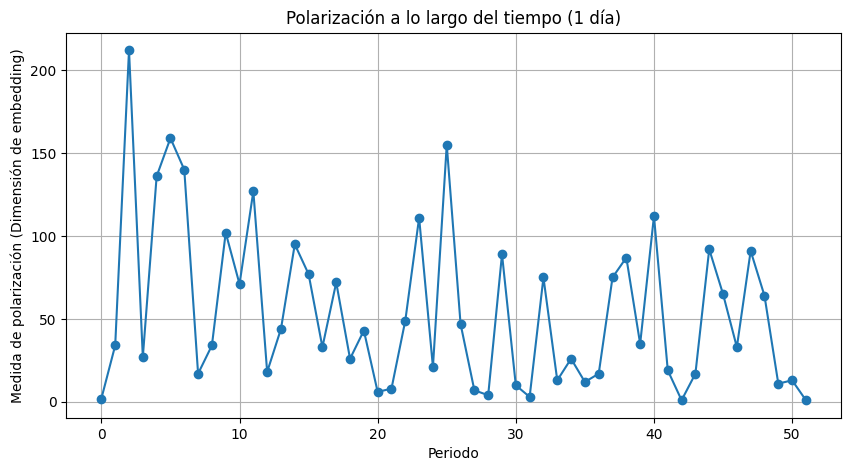

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(ed_1day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo (1 día)')
plt.grid(True)
plt.show()

In [12]:
ed_3day = measure_polarization(graphs, steps=3, accum=False)

Window 2025-02-23: Estimated embedding dimension = 245
Window 2025-02-26: Estimated embedding dimension = 317
Window 2025-03-01: Estimated embedding dimension = 186
Window 2025-03-04: Estimated embedding dimension = 285
Window 2025-03-07: Estimated embedding dimension = 154
Window 2025-03-10: Estimated embedding dimension = 178
Window 2025-03-13: Estimated embedding dimension = 73
Window 2025-03-16: Estimated embedding dimension = 168
Window 2025-03-19: Estimated embedding dimension = 220
Window 2025-03-22: Estimated embedding dimension = 101
Window 2025-03-25: Estimated embedding dimension = 87
Window 2025-03-28: Estimated embedding dimension = 51
Window 2025-03-31: Estimated embedding dimension = 174
Window 2025-04-03: Estimated embedding dimension = 159
Window 2025-04-06: Estimated embedding dimension = 108
Window 2025-04-09: Estimated embedding dimension = 183
Window 2025-04-12: Estimated embedding dimension = 83


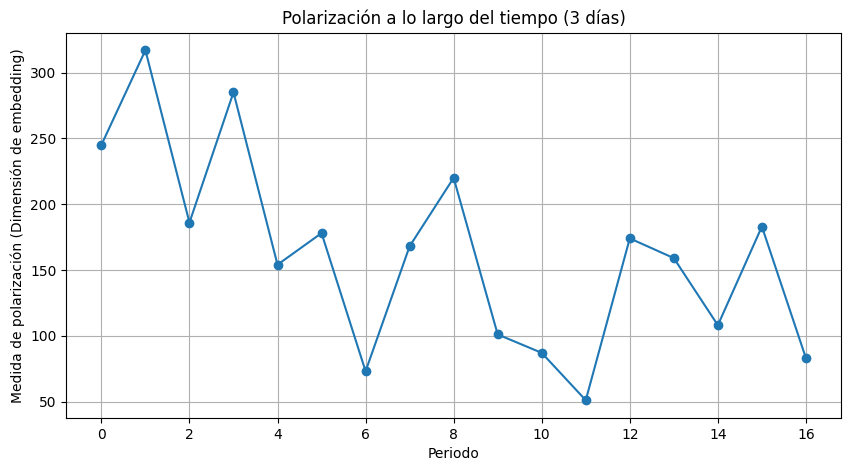

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(ed_3day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo (3 días)')
plt.grid(True)
plt.show()

In [16]:
ed_5day = measure_polarization(graphs, steps=5, accum=False)

Window 2025-02-23: Estimated embedding dimension = 397
Window 2025-02-28: Estimated embedding dimension = 413
Window 2025-03-05: Estimated embedding dimension = 332
Window 2025-03-10: Estimated embedding dimension = 242
Window 2025-03-15: Estimated embedding dimension = 194
Window 2025-03-20: Estimated embedding dimension = 289
Window 2025-03-25: Estimated embedding dimension = 120
Window 2025-03-30: Estimated embedding dimension = 215
Window 2025-04-04: Estimated embedding dimension = 226
Window 2025-04-09: Estimated embedding dimension = 247


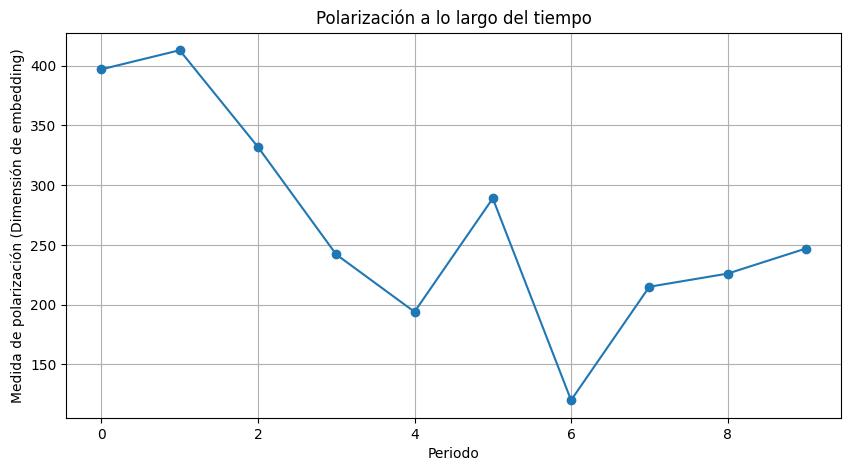

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(ed_5day[0], marker='o')
plt.xlabel('Periodo')
plt.ylabel('Medida de polarización (Dimensión de embedding)')
plt.title('Polarización a lo largo del tiempo')
plt.grid(True)
plt.show()